In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
import os

import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod
from gewitter_functions import get_acc





2024-05-06 16:43:22.412797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ds_train = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Daily_Data_CNN/train_full.nc').isel(time = slice(0,100))
ds_val = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Daily_Data_CNN/validate_full.nc')


In [3]:
batch_size = 64

In [4]:
## make Y data chunking land and ocean together
all_Y = ds_train.labels_1d.values
all_Y_val = ds_val.labels_1d.values
Y_train = []
Y_val = []
for i in range(10):
    Y_train.append(np.max(all_Y[:,[i,i+10]],1))
    Y_val.append(np.max(all_Y_val[:,[i,i+10]],1))
Y_train = np.vstack(Y_train).T
Y_val = np.vstack(Y_val).T

In [11]:
train_random_shuffle = np.arange(len(ds_train.time))
np.random.shuffle(train_random_shuffle )

X_train = ds_train.features.values[train_random_shuffle]
# Y_train = ds_train.labels_1d.values[train_random_shuffle]
# Y_train = ds_train.labels_1d.values[train_random_shuffle]
Y_train = Y_train[train_random_shuffle]

time_train = ds_train.time[train_random_shuffle]

val_random_shuffle = np.arange(len(ds_val.features))
np.random.shuffle(val_random_shuffle)
X_val = ds_val.features.values[val_random_shuffle]
# Y_val = ds_val.labels_1d.values[val_random_shuffle]
# Y_val = ds_val.labels_1d.values[val_random_shuffle]
Y_val = Y_val[val_random_shuffle]
time_val = ds_val.time[val_random_shuffle]

train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_data = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

#batch both 
train_data = train_data.batch(batch_size)
val_data = val_data.batch(batch_size)

for batch in train_data:
    break 
for batch in val_data:
    break 



2024-05-06 16:49:25.770438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [100,10]
	 [[{{node Placeholder/_1}}]]
2024-05-06 16:49:26.191534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2191,10]
	 [[{{node Placeholder/_1}}]]


In [13]:
train_data.element_spec[0].shape[1:]

TensorShape([144, 90, 19])

In [64]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(100, (2, 2), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
#     tf.keras.layers.LeakyReLU(alpha=0.01),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Add max pooling layer

#     tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.GlobalAveragePooling2D(),

#     tf.keras.layers.Dense(200, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(100, activation='relu'),
#     tf.keras.layers.Dense(2,activation='sigmoid'),
# ])

# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(20, (2, 2), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
#     tf.keras.layers.LeakyReLU(alpha=0.01),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Conv2D(20, (2, 2), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
#     tf.keras.layers.LeakyReLU(alpha=0.01),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Conv2D(50, (10, 10), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
#     tf.keras.layers.LeakyReLU(alpha=0.01),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.GlobalAveragePooling2D(),

#     tf.keras.layers.Dense(100, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(100, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(21,activation='sigmoid'),

#     tf.keras.layers.Dense(20,activation='sigmoid'),
# ])

# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(50, (3, 3), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
#     tf.keras.layers.LeakyReLU(alpha=0.01),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Add max pooling layer

#     tf.keras.layers.Conv2D(20, (40, 40), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
#     tf.keras.layers.LeakyReLU(alpha=0.01),
# #     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Add max pooling layer

# #     tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
# #     tf.keras.layers.LeakyReLU(alpha=0.01),
#     tf.keras.layers.Flatten(),
    

#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(20,activation='sigmoid'),
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(train_data.element_spec[0].shape[1:]), activation ='relu'),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(train_data.element_spec[0].shape[1:]), activation ='relu'),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(12, (3, 3), padding='same', input_shape=(train_data.element_spec[0].shape[1:]), activation ='relu'),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Flatten(),
    

    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10,activation='sigmoid'),
])




In [65]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 144, 90, 32)       5504      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 144, 90, 32)       0         
                                                                 
 dropout_12 (Dropout)        (None, 144, 90, 32)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 144, 90, 32)       9248      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 144, 90, 32)       0         
                                                                 
 dropout_13 (Dropout)        (None, 144, 90, 32)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 144, 90, 12)      

In [66]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = .1,patience=5,  verbose = 1, )

In [67]:
## Inputs

epoch_num = 5

# model.compile(loss="categorical_crossentropy",
#               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

# model.compile(loss='mse',
#               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2,
                                               from_logits=False),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

# model.compile(loss='binary_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

In [68]:
history = model.fit(train_data,validation_data=val_data,epochs=epoch_num, callbacks = [callback])


Epoch 1/5
32/32 [==============================] - 28s 845ms/step - loss: 0.1477 - accuracy: 0.0525 - val_loss: 0.1103 - val_accuracy: 0.0552
Epoch 2/5
32/32 [==============================] - 27s 834ms/step - loss: 0.0997 - accuracy: 0.0745 - val_loss: 0.1067 - val_accuracy: 0.0602
Epoch 3/5
32/32 [==============================] - 27s 841ms/step - loss: 0.0938 - accuracy: 0.0955 - val_loss: 0.1042 - val_accuracy: 0.0762
Epoch 4/5
32/32 [==============================] - 28s 877ms/step - loss: 0.0881 - accuracy: 0.1085 - val_loss: 0.1016 - val_accuracy: 0.0844
Epoch 5/5
32/32 [==============================] - 27s 843ms/step - loss: 0.0819 - accuracy: 0.1355 - val_loss: 0.1007 - val_accuracy: 0.1027


In [332]:
len(history.history['loss']) 

8

In [69]:
history_pd = pd.DataFrame(history.history)
y_preds_distribution = model.predict(val_data)


results_pd = pd.DataFrame(y_preds_distribution)
results_pd = results_pd.set_index(np.array(time_val))

val_pd = pd.DataFrame(Y_val)
val_pd = val_pd.set_index(np.array(time_val))


35/35 [==============================] - 4s 117ms/step


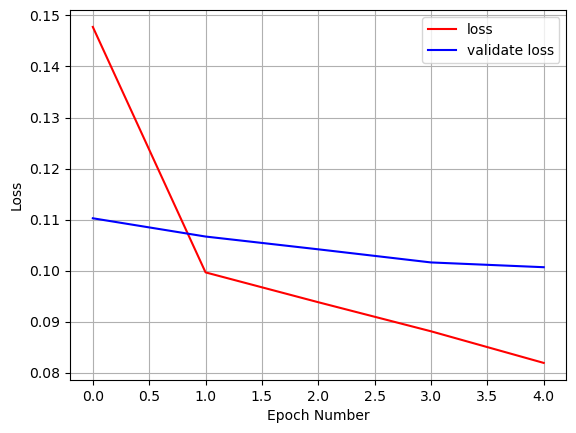

In [70]:
plt.plot(history_pd['loss'],'-r', label = 'loss')
plt.plot(history_pd['val_loss'],'-b', label = 'validate loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


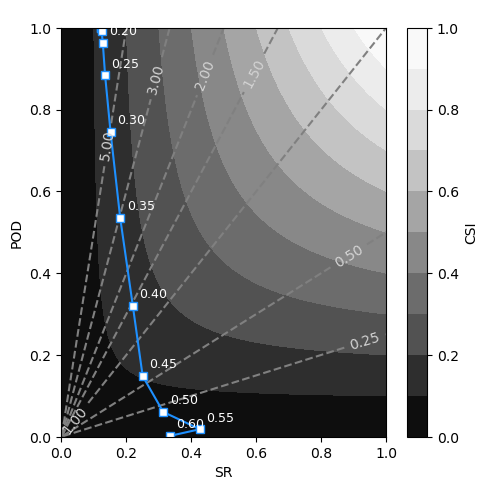

In [71]:
#ravel both
y_v_rav =np.array(val_pd).ravel()
y_preds_rav = np.array(results_pd).ravel()

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v_rav,y_preds_rav)
fps = fp(y_v_rav,y_preds_rav)
fns = fn(y_v_rav,y_preds_rav)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)


#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,fontsize=9,color='white')

plt.tight_layout();

In [72]:
cutoff = .45

predict_pd = np.zeros((len(results_pd.columns), len(results_pd)))
for c in range(len(results_pd.columns)):
    predict_pd[c] = np.where(results_pd[c]>cutoff,1,0).squeeze()
predict_pd = pd.DataFrame(predict_pd.T, index = results_pd.index)

#the contingency table calculator expects y_true,y_pred
cont_table = get_contingency_table(np.array(val_pd),np.array(predict_pd))

accuracy = get_acc(cont_table)
print('Percent of AR Correctly Detected = {}%'.format(np.round(cont_table['num_true_positives']/np.sum(np.array(val_pd))*100,0)))
print('Percent of noAR Correctly Detected = {}%'.format(np.round(cont_table['num_true_negatives']/np.sum(np.where(np.array(val_pd) ==0,1,0))*100,0)))
print('Binary Accuracy = {}%'.format(np.round(accuracy,0)))
print(cont_table)
print('number of true positives (actual): ' +str(np.sum(np.array(val_pd))))
print('number of true negatives (actual): ' +str(np.sum(np.where(np.array(val_pd) ==0,1,0))))

Percent of AR Correctly Detected = 15.0%
Percent of noAR Correctly Detected = 94.0%
Binary Accuracy = 84.0%
{'num_true_positives': 396, 'num_false_positives': 2275, 'num_false_negatives': 1187, 'num_true_negatives': 18052}
number of true positives (actual): 2671
number of true negatives (actual): 19239


In [73]:

predict_pd[np.sum(val_pd,1)==0]

,0,1,2,3,4,5,6,7,8,9
2010-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996-10-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-17,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2000-10-05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986-11-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-03-22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995-05-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
val_pd[np.sum(val_pd,1)>0]

,0,1,2,3,4,5,6,7,8,9
1997-10-11,0,0,0,0,0,0,1,1,0,0
1995-11-07,0,0,0,0,0,0,1,0,0,0
1996-10-09,0,1,1,0,0,0,0,0,0,0
2003-04-20,0,1,0,0,0,0,1,1,1,0
1980-06-03,0,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1980-08-16,1,0,0,0,0,0,0,0,0,0
1987-08-19,0,1,0,0,0,0,0,1,1,0
1984-09-22,0,0,0,0,0,0,1,1,0,0
1992-07-19,0,0,0,0,0,0,1,1,0,0


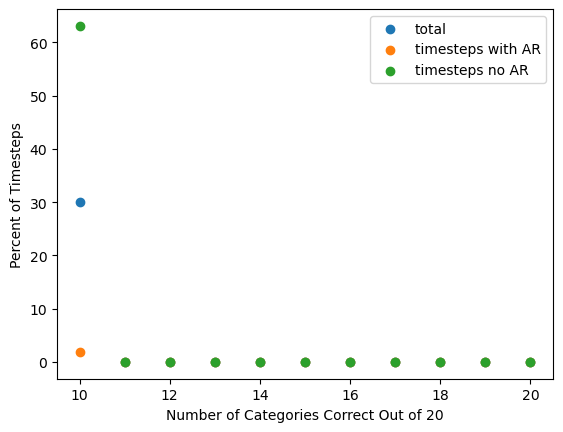

In [75]:
perc_correct_total = []
perc_correct_withAR = []
perc_correct_noAR = []

for n in np.arange(10,21,1):    
    perc_correct_total.append((np.where(np.sum(np.array(predict_pd) == np.array(val_pd),1)>=n,1,0).sum()/len(val_pd)))
    perc_correct_noAR.append((np.where(np.sum(np.array(predict_pd[np.sum(val_pd,1)==0]) == np.array(val_pd[np.sum(val_pd,1)==0]),1)>=n,1,0).sum()/len(val_pd[np.sum(val_pd,1)==0])))
    perc_correct_withAR.append((np.where(np.sum(np.array(predict_pd[np.sum(val_pd,1)>0]) == np.array(val_pd[np.sum(val_pd,1)>0]),1)>=n,1,0).sum()/len(val_pd[np.sum(val_pd,1)>0])))
    
plt.scatter(np.arange(10,21,1), np.array(perc_correct_total)*100, label = 'total')
plt.scatter(np.arange(10,21,1), np.array(perc_correct_withAR)*100, label = 'timesteps with AR')
plt.scatter(np.arange(10,21,1), np.array(perc_correct_noAR)*100, label = 'timesteps no AR')

plt.ylabel('Percent of Timesteps')
plt.xlabel('Number of Categories Correct Out of 20')
plt.legend()

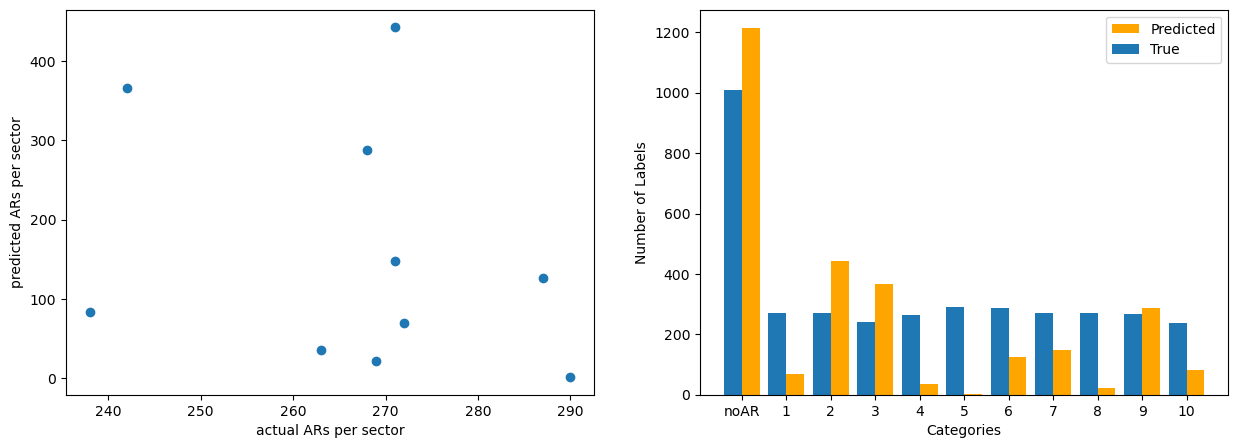

In [78]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].scatter(np.sum(np.array(val_pd),0), np.sum(np.array(predict_pd),0))
ax[0].set_ylabel('predicted ARs per sector')
ax[0].set_xlabel('actual ARs per sector')

ax[1].bar(np.arange(0,11)+.2, np.append(np.sum(np.where(np.sum(predict_pd,1)>0,0,1)),np.sum(np.array(predict_pd), axis = 0))
          , width= .4,  color = 'orange', label = 'Predicted')
ax[1].bar(np.arange(0,11)-.4, np.append(np.sum(np.where(np.sum(val_pd,1)>0,0,1)),np.sum(np.array(val_pd), axis = 0))
          , width =.4, align = 'edge', label = 'True')

ax[1].set_ylabel('Number of Labels')
ax[1].set_xlabel('Categories')
ax[1].set_xticks(np.arange(0,11,1))
ax[1].set_xticklabels(['noAR','1','2','3','4','5','6','7','8','9','10',])# '11','12','13','14','15','16','17','18','19','20'])
ax[1].legend()


## check out one category

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


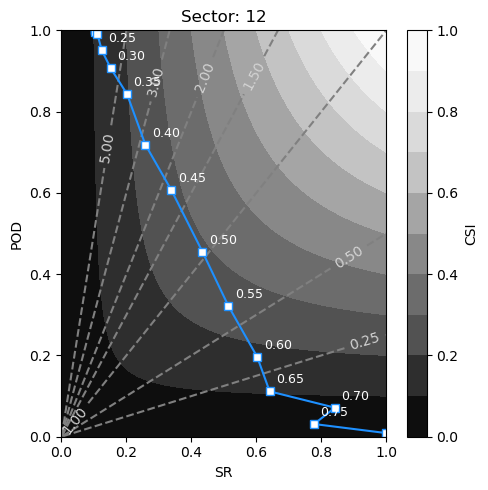

In [27]:
c =12

if c ==0: #no AR timesteps
    y_v_rav = np.where(np.sum(val_pd,1)==0,1,0)
    y_preds_rav = 1-np.max(results_pd, 1)

else:
    y_v_rav =np.array(val_pd[[c]]).ravel()
    y_preds_rav = np.array(results_pd[[c]]).ravel()

#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(y_v_rav,y_preds_rav)
fps = fp(y_v_rav,y_preds_rav)
fns = fn(y_v_rav,y_preds_rav)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)


#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
    ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,fontsize=9,color='white')

ax.set_title('Sector: '+str(c))
plt.tight_layout();

### check out one timestep of data

In [24]:
pd.DataFrame(np.array(batch[1]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0
62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


Text(0, 0.5, 'Predicted Likelihood')

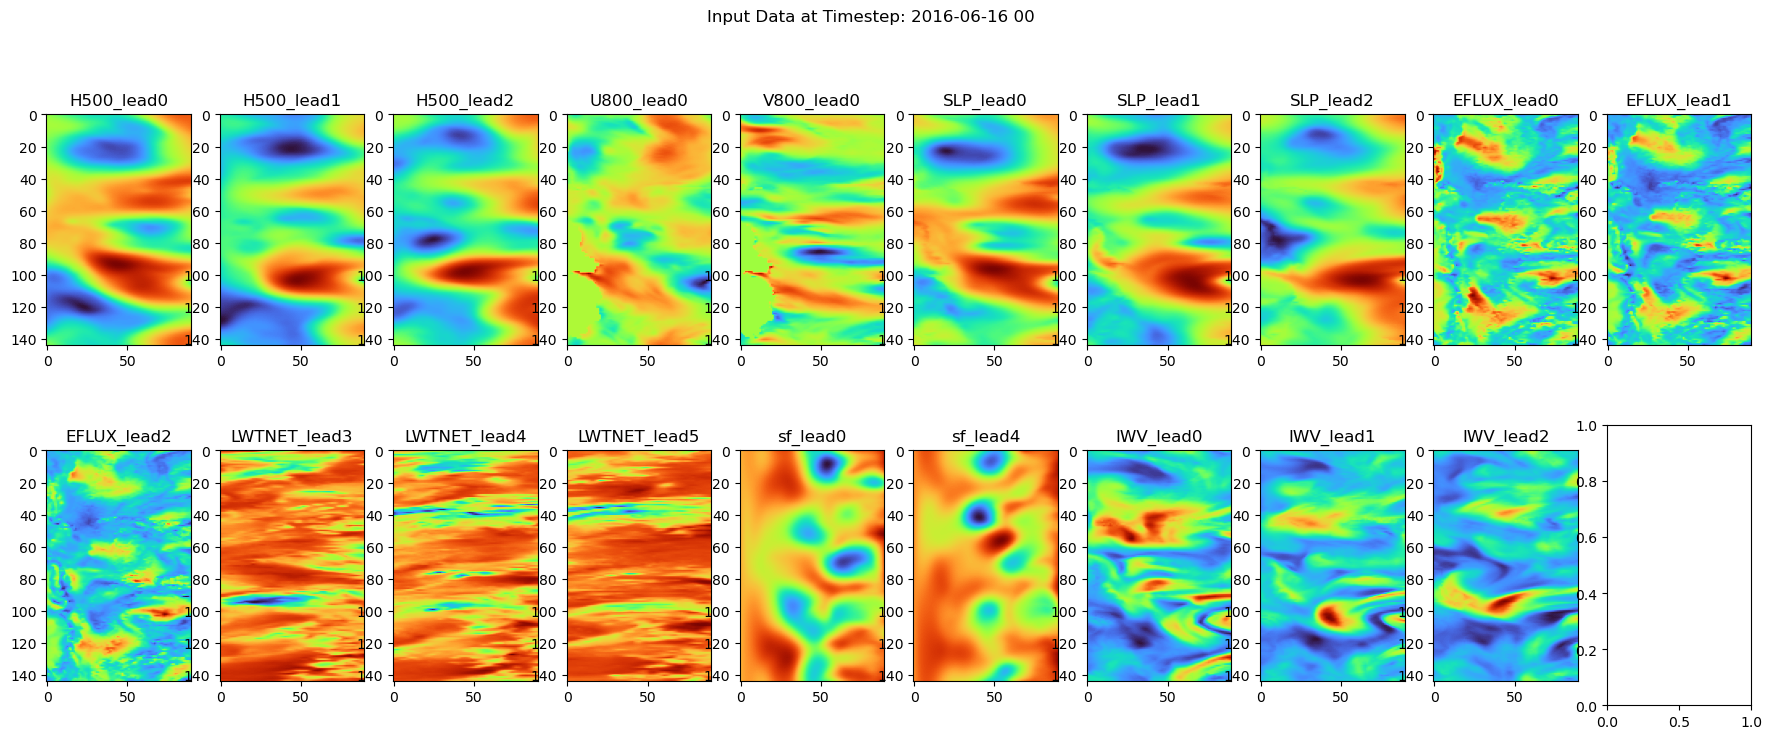

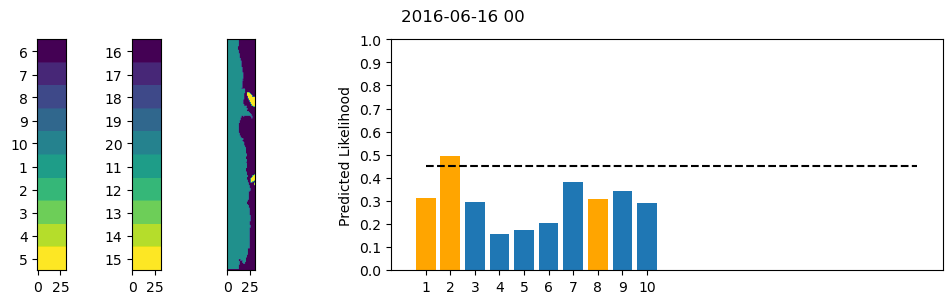

In [80]:
n = 62

#get the features for example 12 in this batch 
one_example_features = batch[0][n]
#get the label for that same example 
one_example_label = batch[1][n]

Y_data = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Y_labels_AR_PRECSN_T/'+str(pd.to_datetime(time_val[n].values).year))
Y_data = Y_data.resample(time = '24H').max()
Y_visual_data = xr.where(Y_data.Y>=1000,1, 0) 
Y_visual_data = xr.where(Y_data.Y.isin([100, 101, 110, 111, 1100, 1101, 1110, 1111]),2, Y_visual_data ) 
Y_visual_data = Y_visual_data.sel(time = time_val[n].values).values.T

# Make category visual
lons = np.shape(batch[0])[1]
start = np.round(np.arange(0,lons,lons/10))
end = np.round(np.arange(lons/10,lons+lons/10, lons/10))
show_categories = np.zeros((np.shape(batch[0])[0:2][1],np.shape(batch[0])[0:2][0]))
for c in range(10):
    show_categories[int(start[c]):int(end[c]),:] = c+1

#get the features for example 12 in this batch 
one_example_features = batch[0][n]
#get the label for that same example 
one_example_label = batch[1][n]

titles = [
    'H500_lead0', 'H500_lead1', 'H500_lead2','U800_lead0', 'V800_lead0','SLP_lead0', 'SLP_lead1', 'SLP_lead2',
    'EFLUX_lead0', 'EFLUX_lead1', 'EFLUX_lead2', 'LWTNET_lead3', 'LWTNET_lead4', 'LWTNET_lead5','sf_lead0','sf_lead4',
    'IWV_lead0', 'IWV_lead1', 'IWV_lead2',]


fig,axes = plt.subplots(2,10,figsize=(22,8))
fig.suptitle('Input Data at Timestep: '+str(pd.to_datetime(time_val[n].values))[0:13])
axes = axes.flatten()
for a in range(len(axes)-1):
    axes[a].imshow(one_example_features[:,:,a],cmap='turbo')
    axes[a].set_title(titles[a])

# Make category visual
lons = np.shape(Y_visual_data)[0]
start = np.round(np.arange(0,lons,lons/10))
end = np.round(np.arange(lons/10,lons+lons/10, lons/10))
show_categories = np.zeros((np.shape(Y_visual_data)[0],np.shape(Y_visual_data)[1]))
for c in range(10):
    show_categories[int(start[c]):int(end[c]),:] = c+1

    

fig = plt.figure(figsize=(12, 3), constrained_layout=False)
fig.suptitle(str(pd.to_datetime(time_val[n].values))[0:13])
gs = fig.add_gridspec(1, 10)
ax1 = fig.add_subplot(gs[0, :1])
ax4 = fig.add_subplot(gs[0, 1:2])
ax2 = fig.add_subplot(gs[0,2:3])
ax3 = fig.add_subplot(gs[0, 4:])

# ax1.imshow(show_categories, cmap = 'jet')
# ax4 = ax1.twinx()
ax1.set_yticks(np.round(np.arange(0,lons,lons/10))+lons/20)
ax1.set_yticklabels(['6','7','8','9','10','1','2','3','4','5',])
# ax4.set_yticklabels(['16','17','18','19','20','11','12','13','14','15',])
ax1.imshow(show_categories)


ax4.set_yticks(np.round(np.arange(0,lons,lons/10))+lons/20)
ax4.set_yticklabels(['16','17','18','19','20','11','12','13','14','15',])
ax4.imshow(show_categories)


ax2.imshow(Y_visual_data, )
ax2.set_yticks([])

ax3.bar(np.arange(0,10,1),results_pd.iloc[n])
ax3.bar(np.argwhere(val_pd.iloc[n] == 1).squeeze(),results_pd.iloc[n][np.argwhere(val_pd.iloc[n] == 1).squeeze()], color = 'orange')
ax3.set_xticks(np.arange(0,10,1), ['1','2','3','4','5','6','7','8','9','10',])#'11','12','13','14','15','16','17','18','19','20']);
ax3.hlines(cutoff, xmin = 0, xmax = 20, linestyles='--', color = 'black')
ax3.set_yticks(np.arange(0,1.1,.1))
ax3.set_ylabel('Predicted Likelihood')
    

## Save the particular model

In [ ]:
y_preds_distribution = model.predict(val_data)


results_pd = pd.DataFrame(y_preds_distribution)
results_pd = results_pd.set_index(np.array(time_val))

val_pd = pd.DataFrame(Y_val)
val_pd = val_pd.set_index(np.array(time_val))


new_folder = '/rc_scratch/reba1583/CNN_daily1'
os.system('mkdir '+new_folder)
results_pd.to_csv(new_folder+'/results.csv')
val_pd.to_csv(new_folder+'/val.csv')
model.save(new_folder+'/model.keras')
history_pd.to_csv(new_folder+'/history.csv',index= False)

## look at model layers

In [29]:
## Checkout certain layer 
for l,layer in enumerate(model.layers):
    print(l,layer.name)

0 conv2d_3
1 leaky_re_lu_3
2 dropout_3
3 conv2d_4
4 leaky_re_lu_4
5 dropout_4
6 conv2d_5
7 leaky_re_lu_5
8 dropout_5
9 flatten_1
10 dense_2
11 dense_3


In [30]:
#identify the convolutional layer
conv_layer = model.get_layer('conv2d_5')

#re-wire a model to take the normal model inputs, but now just output the result of the convolution
conv_output = tf.keras.models.Model([model.inputs], [conv_layer.output])

#run the model the same way, to see what the output convovled image
convolved_images = conv_output.predict(val_data)

#grab a batch to look at 
for batch in val_data:
    break 


35/35 [==============================] - 4s 111ms/step


In [31]:
np.shape(convolved_images)

(2191, 144, 90, 6)

In [32]:
plot_convolved_images = convolved_images[0]
np.shape(plot_convolved_images)

(144, 90, 6)

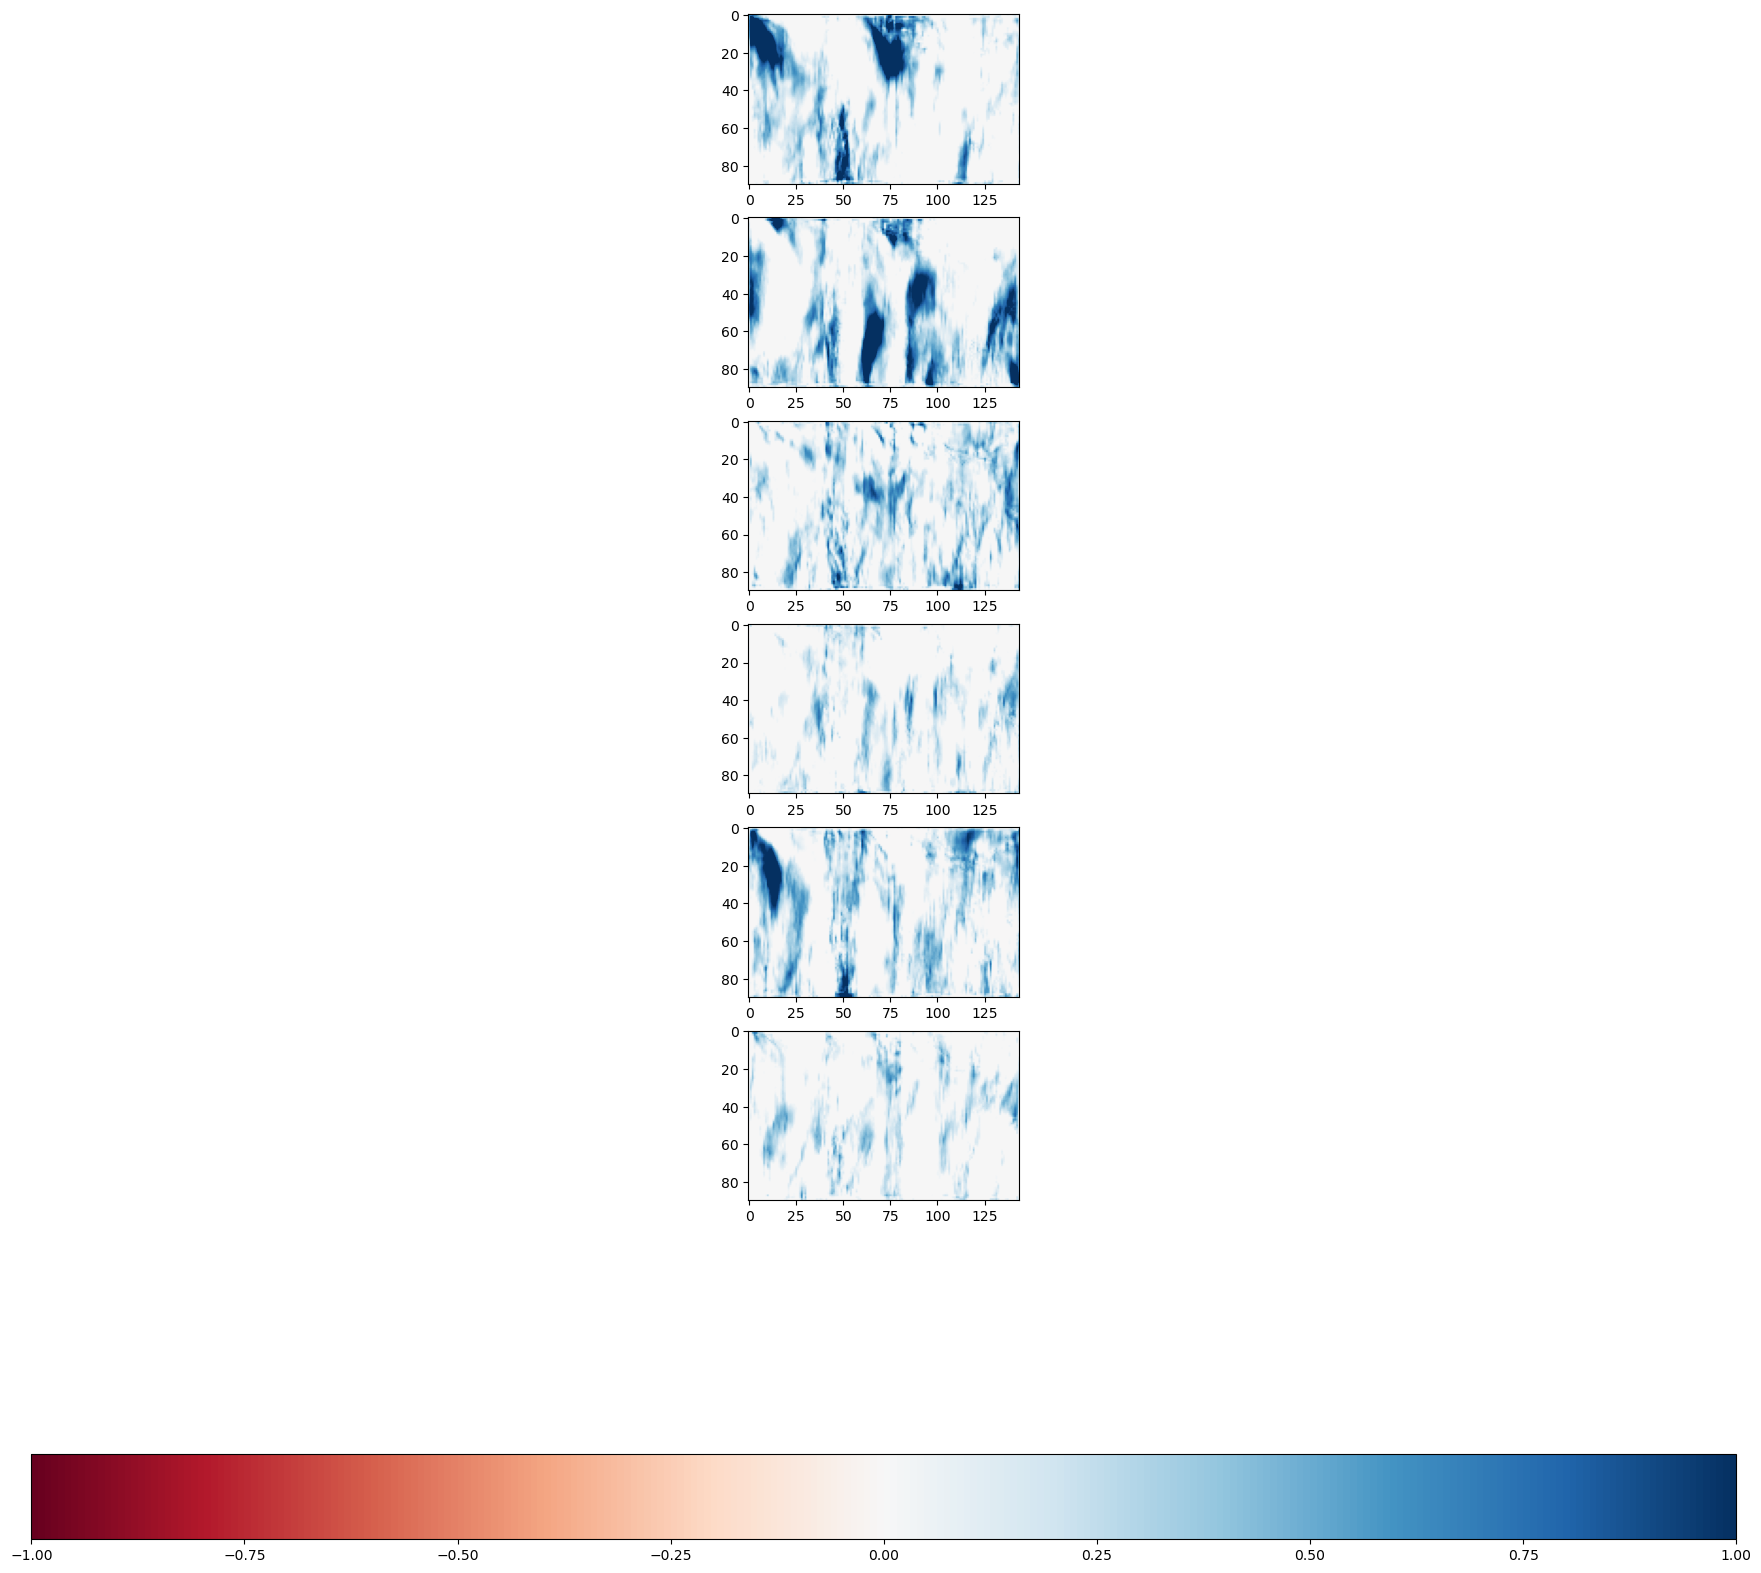

In [35]:

# fig,ax = plt.subplots(5,10,figsize=(22,22))

fig,ax = plt.subplots(6,1,figsize=(22,22))
axes = ax.flatten()
for a in range(len(axes)):
    im = axes[a].imshow(plot_convolved_images[:,:,a].T, vmin = -1, vmax = 1,cmap='RdBu')
fig.colorbar(im, ax = axes.ravel(), orientation = 'horizontal')
    



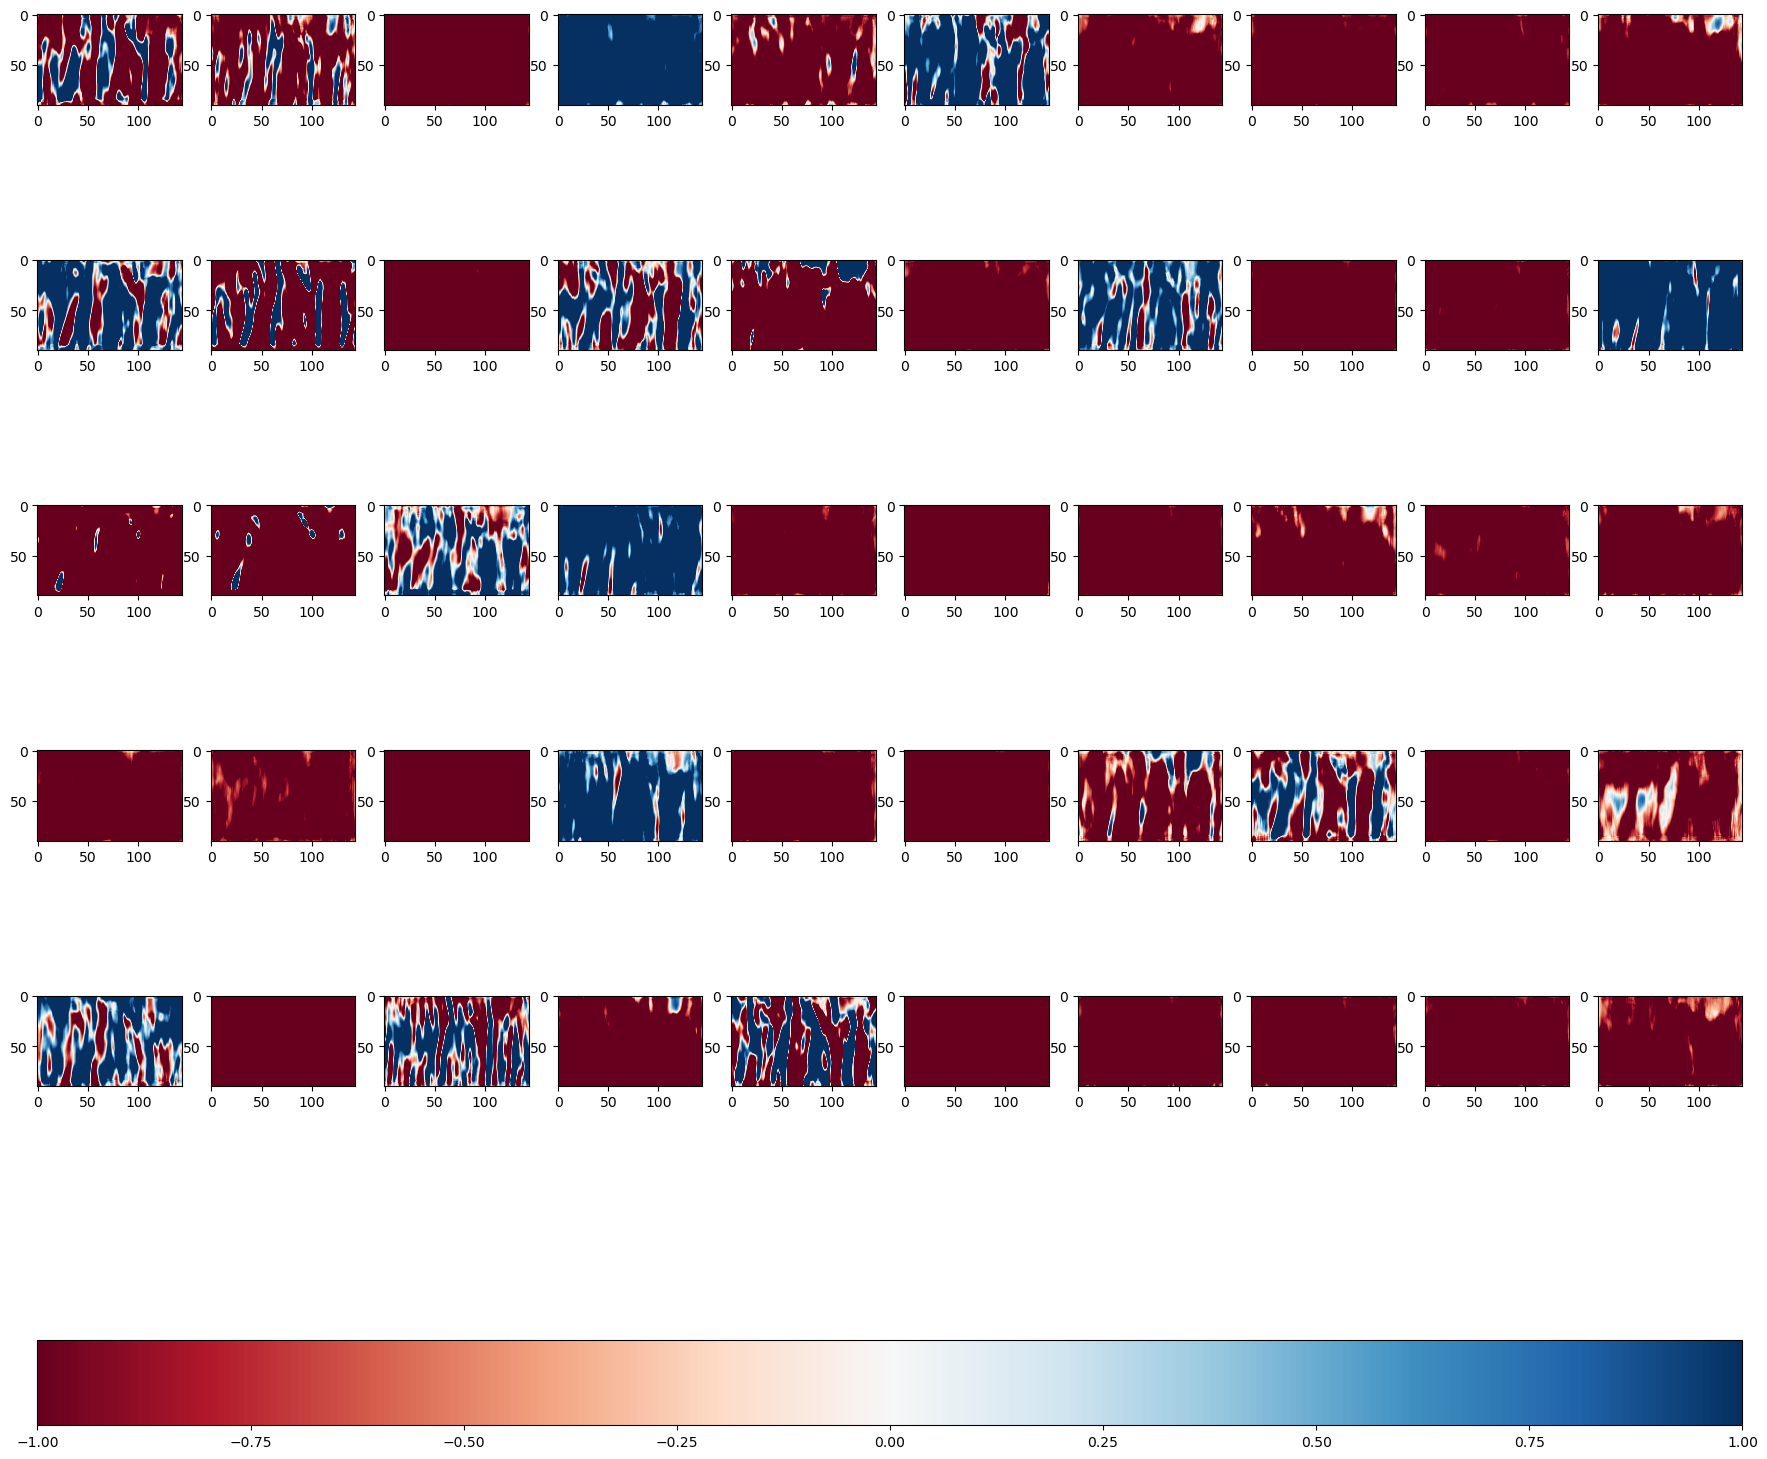

In [52]:
plot_convolved_images = convolved_images[20]
fig,ax = plt.subplots(5,10,figsize=(22,22))
axes = ax.flatten()
for a in range(len(axes)):
    im = axes[a].imshow(plot_convolved_images[:,:,a].T, vmin = -1, vmax = 1,cmap='RdBu')
fig.colorbar(im, ax = axes.ravel(), orientation = 'horizontal')
    

